In [0]:
#%matplotlib notebook
import numpy as np
import cvxpy
import math
import time
import matplotlib.pyplot as plt
import matplotlib
#import matplotlib.animation as animation
#import IPython

In [0]:
pendulum_length = 3.0  # length of bar
M_cart = 1.0  # [kg]
m_pendulum = 0.5  # [kg]
g = 9.8  # [m/s^2]

Q = np.diag([0.0, 1.0, 1.0, 0.0])
R = np.diag([0.01])
nx = 4   # number of state
nu = 1   # number of input
HL = 30  # Horizon length
delta_t = 0.1  # time tick

In [0]:
def make_equation(x, u):
    A, B = model()
    x = np.dot(A, x) + np.dot(B, u)
    return x

In [0]:
def mpc(x0):
    x = cvxpy.Variable((nx, HL + 1))
    u = cvxpy.Variable((nu, HL))

    A, B = model()

    cost = 0.0
    constraint = []
    for l in range(HL):
        cost += cvxpy.quad_form(x[:, l + 1], Q)
        cost += cvxpy.quad_form(u[:, l], R)
        constraint += [x[:, l + 1] == A * x[:, l] + B * u[:, l]]
    # print(x0)
    constraint += [x[:, 0] == x0[:, 0]]
    prob = cvxpy.Problem(cvxpy.Minimize(cost), constraint)

    start = time.time()
    prob.solve(verbose=False)
    elapsed_time = time.time() - start
    print("calculated time:{0} [sec]".format(elapsed_time))

    if prob.status == cvxpy.OPTIMAL:
        ox = np.array(x.value[0, :]).flatten()
        dx = np.array(x.value[1, :]).flatten()
        theta = np.array(x.value[2, :]).flatten()
        dtheta = np.array(x.value[3, :]).flatten()

        ou = np.array(u.value[0, :]).flatten()

    return ox, dx, theta, dtheta, ou

In [0]:
#def get_nparray_from_matrix(x):
 #   """
  #  get build-in list from matrix
   # """
    #return np.array(x).flatten()


def model():
    A = np.array([
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, m_pendulum * g / M_cart, 0.0],
        [0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, g * (M_cart + m_pendulum) / (pendulum_length * M_cart), 0.0]
    ])
    A = np.eye(nx) + delta_t * A

    B = np.array([
        [0.0],
        [1.0 / M_cart],
        [0.0],
        [1.0 / (pendulum_length * M_cart)]
    ])
    B = delta_t * B

    return A, B

In [0]:
def cart_pole_frame(xt, theta):
    
    width_cart = 1.0
    radius = 0.1
    height_cart = 0.5
    
    
    cx = np.matrix([-width_cart / 2.0, width_cart / 2.0, width_cart /
                    2.0, -width_cart / 2.0, -width_cart / 2.0]) #cart x axis
    cy = np.matrix([0.0, 0.0, height_cart, height_cart, 0.0]) #cart y axis
    cy += radius * 2.0

    cx = cx + xt    
    
    angles = np.arange(0.0, math.pi * 2.0, math.radians(3.0))
    ox = [radius * math.cos(i) for i in angles] #pendulum bob x axis
    oy = [radius * math.sin(i) for i in angles] #pendulum bob y axis
    
    bx = np.matrix([0.0, pendulum_length * math.sin(-theta)]) #bar x axis
    bx += xt
    by = np.matrix([height_cart, pendulum_length * math.cos(-theta) + height_cart]) #bar y axis
    by += radius * 2.0

    wx = np.copy(ox) + float(bx[0, -1]) #pendulum bob linear x axis
    wy = np.copy(oy) + float(by[0, -1]) #pendulum bob linear y axis
    
    rwx = np.copy(ox) + width_cart / 4.0 + xt #right wheel x axis
    rwy = np.copy(oy) + radius                #right wheel y axis
    lwx = np.copy(ox) - width_cart / 4.0 + xt #left wheel x axis
    lwy = np.copy(oy) + radius                #left wheel y axis


    plt.plot(np.array(cx).flatten(), np.array(cy).flatten(), "-c")
    plt.plot(np.array(bx).flatten(), np.array(by).flatten(), "-g")
    plt.plot(np.array(rwx).flatten(), np.array(rwy).flatten(), "-k")
    plt.plot(np.array(lwx).flatten(), np.array(lwy).flatten(), "-k")
    plt.plot(np.array(wx).flatten(), np.array(wy).flatten(), "-r")
    plt.title("x:" + str(round(xt, 2)) + ",theta:" +
              str(round(math.degrees(theta), 2)))

    plt.axis("equal")

In [0]:
def visualize():

    #  x = 1.0
    #  theta = math.radians(10.0)
    #  cart_pole_frame(x, theta)
    #  plt.show()

    angles = np.arange(-math.pi / 2.0, math.pi / 2.0, math.radians(1.0))

    xl = [2.0 * math.cos(i) for i in angles]

    for x, theta in zip(xl, angles):
        plt.clf()
        cart_pole_frame(x, theta)
        plt.pause(0.001)


In [0]:
"""def animate_cart_pole(x):
    """
    """ This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation"""
    """
    
    #subsample
    plotx = x[:,0::5]
    
    fig = matplotlib.figure.Figure(figsize=[6,2.3])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-3,3], ylim=[-1.,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 1
    cart_height = 0.5
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[2,i])
        y_pend = cart_height - np.cos(plotx[2,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])), interval=50, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))"""

IndentationError: unexpected indent (<ipython-input-28-c00fb812812a>, line 3)

calculated time:0.20087242126464844 [sec]


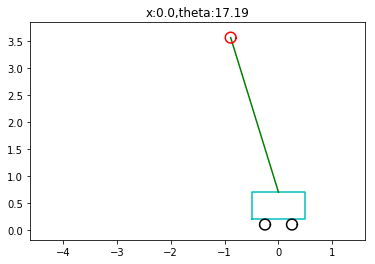

calculated time:0.1419377326965332 [sec]


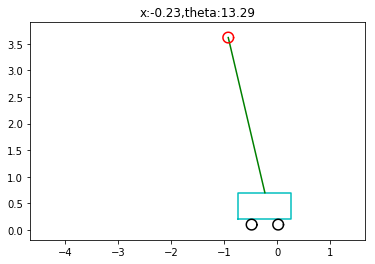

calculated time:0.1719207763671875 [sec]


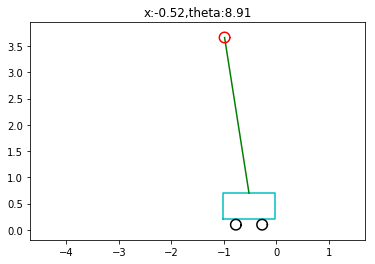

calculated time:0.16588568687438965 [sec]


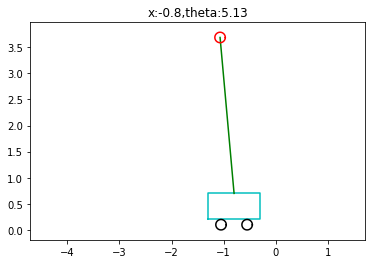

calculated time:0.16689205169677734 [sec]


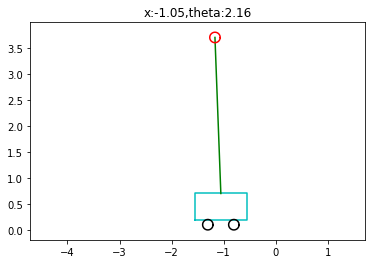

calculated time:0.17091989517211914 [sec]


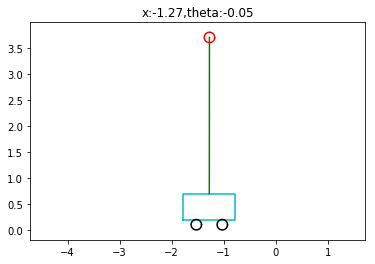

calculated time:0.21587562561035156 [sec]


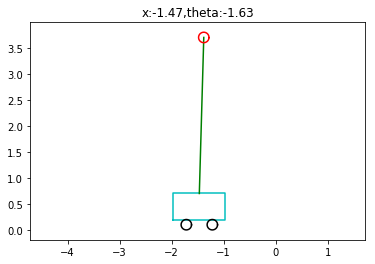

calculated time:0.14693474769592285 [sec]


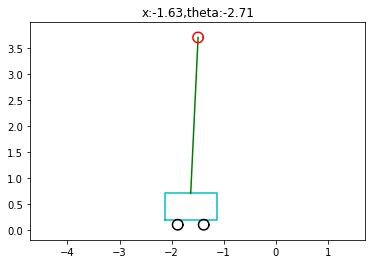

calculated time:0.18590831756591797 [sec]


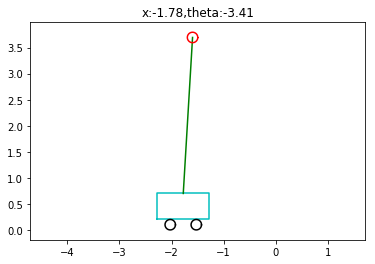

calculated time:0.14391279220581055 [sec]


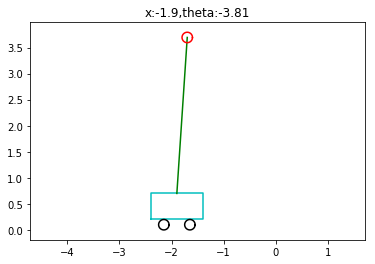

calculated time:0.14591622352600098 [sec]


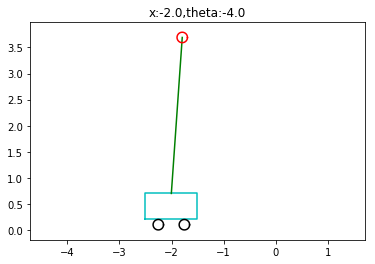

calculated time:0.1499347686767578 [sec]


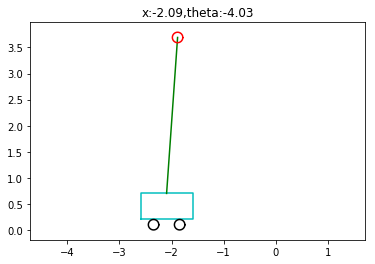

calculated time:0.14191794395446777 [sec]


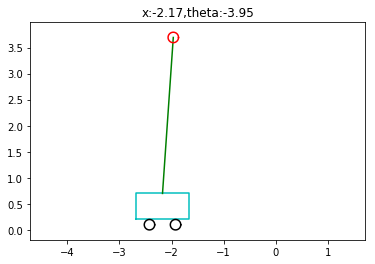

calculated time:0.14291763305664062 [sec]


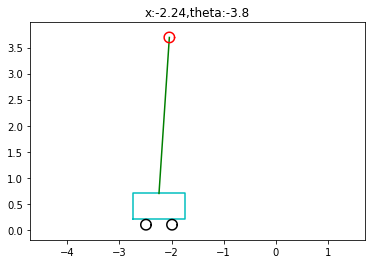

calculated time:0.14992952346801758 [sec]


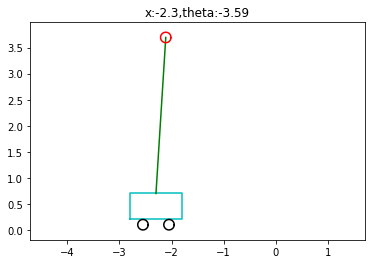

calculated time:0.1779162883758545 [sec]


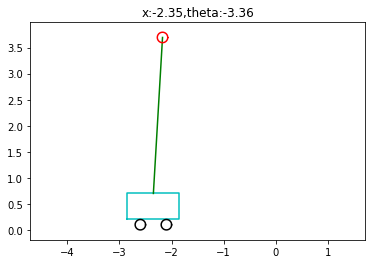

calculated time:0.1509079933166504 [sec]


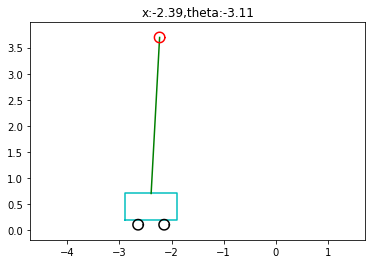

calculated time:0.28583502769470215 [sec]


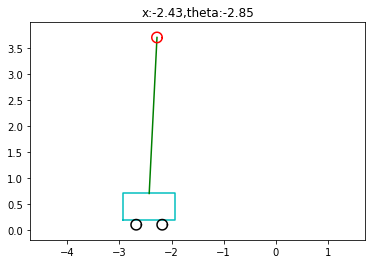

calculated time:0.2548527717590332 [sec]


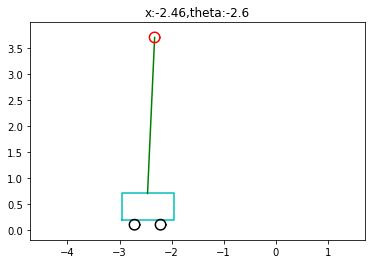

calculated time:0.19189119338989258 [sec]


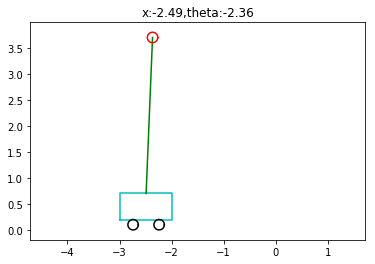

calculated time:0.17689847946166992 [sec]


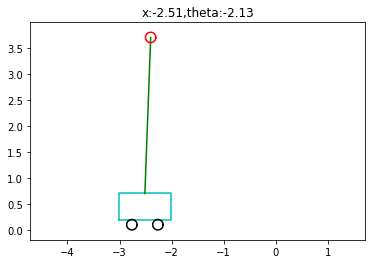

calculated time:0.17291927337646484 [sec]


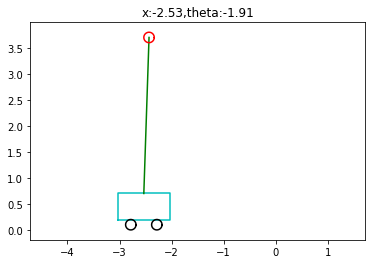

calculated time:0.16791677474975586 [sec]


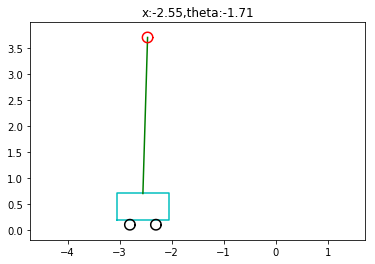

calculated time:0.15890884399414062 [sec]


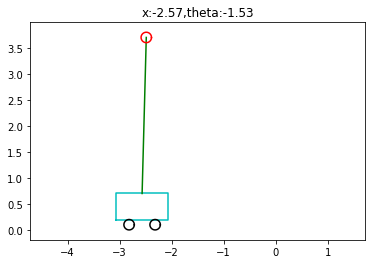

calculated time:0.1449129581451416 [sec]


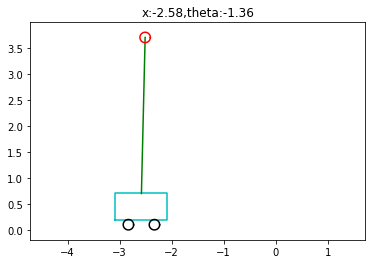

calculated time:0.27582335472106934 [sec]


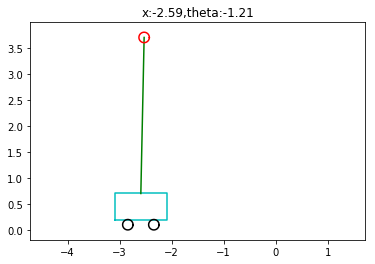

calculated time:0.14992856979370117 [sec]


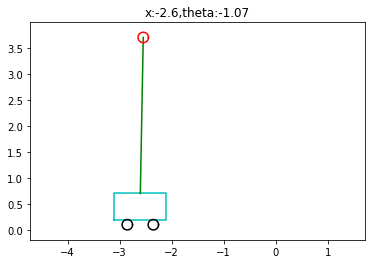

calculated time:0.1859114170074463 [sec]


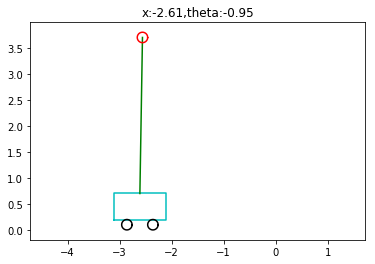

calculated time:0.18789005279541016 [sec]


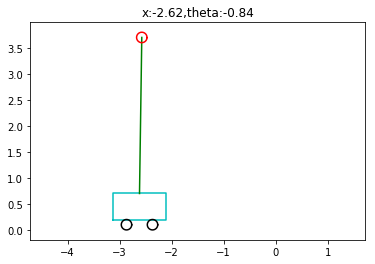

calculated time:0.1608889102935791 [sec]


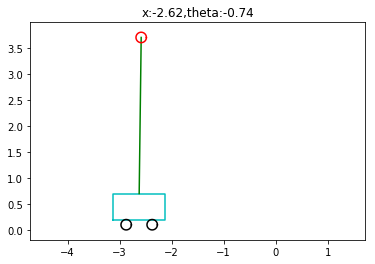

calculated time:0.17191362380981445 [sec]


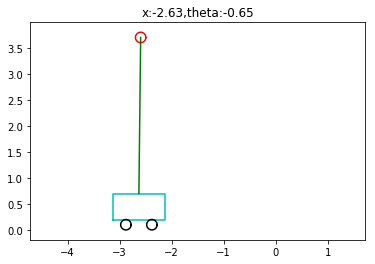

calculated time:0.17188572883605957 [sec]


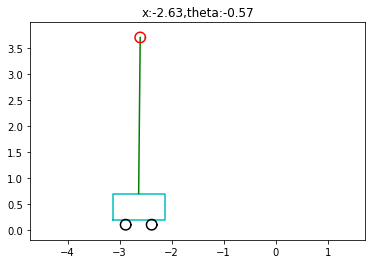

calculated time:0.15192937850952148 [sec]


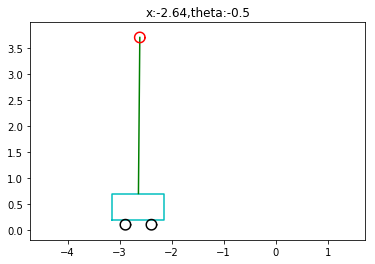

calculated time:0.17290258407592773 [sec]


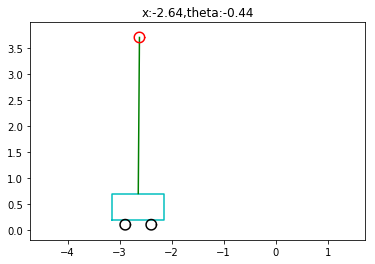

calculated time:0.1688854694366455 [sec]


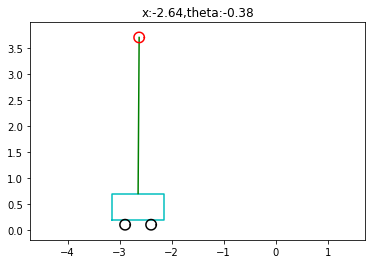

calculated time:0.17090177536010742 [sec]


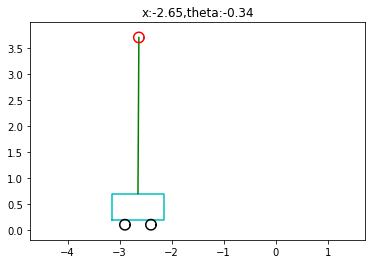

calculated time:0.1479320526123047 [sec]


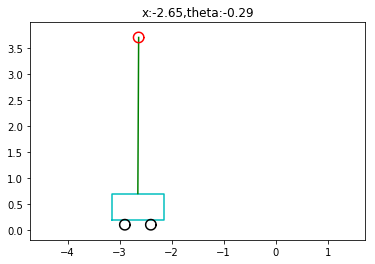

calculated time:0.16492390632629395 [sec]


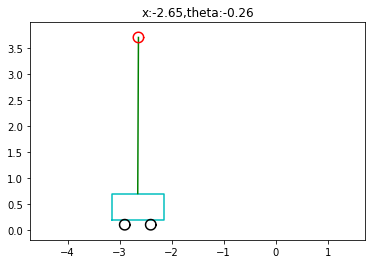

calculated time:0.15391254425048828 [sec]


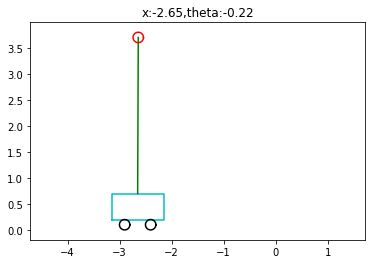

calculated time:0.19588828086853027 [sec]


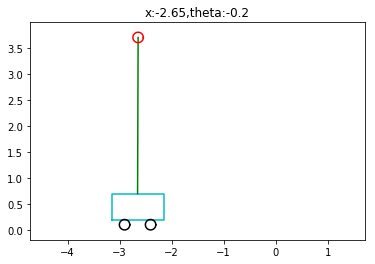

calculated time:0.16888642311096191 [sec]


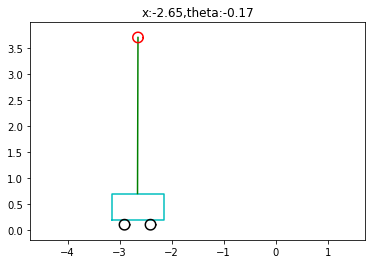

calculated time:0.15091300010681152 [sec]


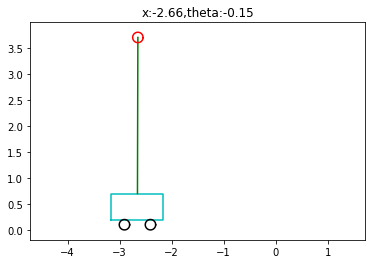

calculated time:0.16190719604492188 [sec]


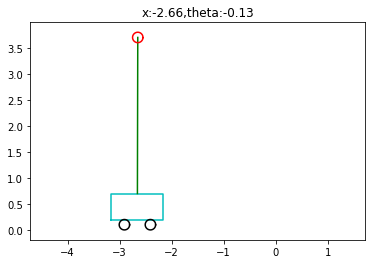

calculated time:0.1499309539794922 [sec]


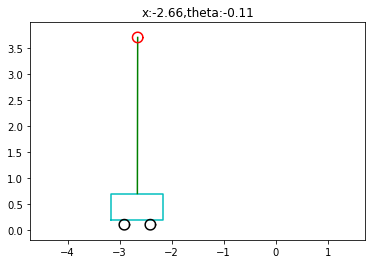

calculated time:0.16190290451049805 [sec]


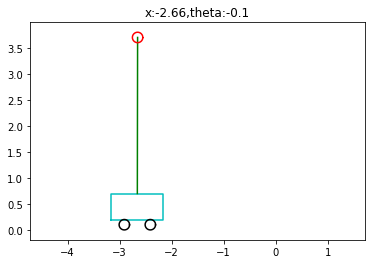

calculated time:0.15990996360778809 [sec]


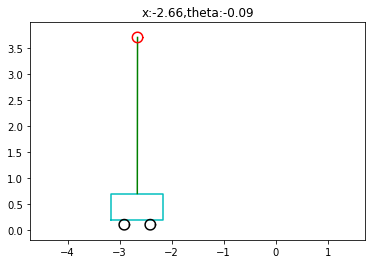

calculated time:0.16388869285583496 [sec]


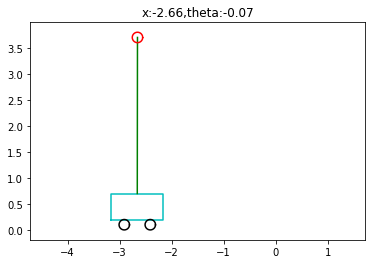

calculated time:0.16091132164001465 [sec]


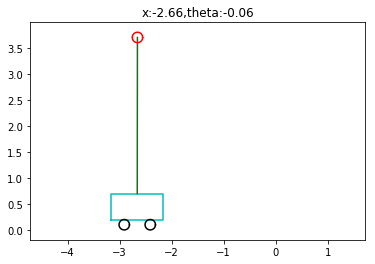

calculated time:0.16988468170166016 [sec]


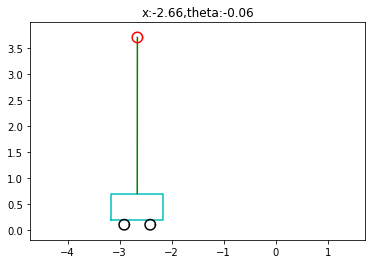

calculated time:0.16988801956176758 [sec]


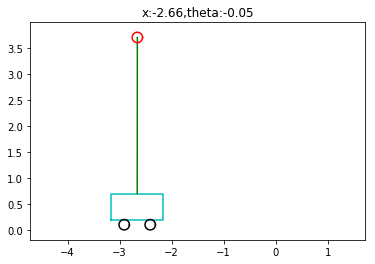

In [0]:
#pendulum_length = 2.0  # length of bar
#M_cart = 1.0  # [kg]
#m_pendulum = 0.3  # [kg]
#g = 9.8  # [m/s^2]

#Q = np.diag([0.0, 1.0, 1.0, 0.0])
#R = np.diag([0.01])
#nx = 4   # number of state
#nu = 1   # number of input
#HL = 30  # Horizon length
#delta_t = 0.1  # time tick

animate = True


x0 = np.array([[0.0],[0.0],[0.3],[0.0]])
x = np.copy(x0)
xd = np.zeros([4, 100])

for i in range(50):
    ox, dx, otheta, dtheta, ou = mpc(x)
    u = ou[0]
    x = make_equation(x, u)
    xd[:,[i]] = x
    
    if animate:
            plt.clf()
            px = float(x[0])
            theta = float(x[2])
            cart_pole_frame(px, theta)
            plt.xlim([-5.0, 2.0])
            plt.pause(0.001)

#visualize()
#print(xd)            

#animate_cart_pole(xd)